# antiquotadu

In [88]:
import json

with open('antiquotadu/result.json') as f:
    my_json = json.load(f)

In [89]:
import pandas as pd
my_keys = set()
emojis = set()
hashtags = set()
for message in my_json['messages']:
    if pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06"):
        my_keys = my_keys.union(set(message.keys()))
        if ('reactions' in message) and (len(message['reactions']) >0):
            for rxn in message['reactions']:
                emojis.add(rxn['emoji'])
        if ('text_entities' in message) and (len(message['text_entities'] )> 0):
            hashtags = hashtags.union(set([i['text'] for i in message['text_entities'] if i['type']=='hashtag']))


In [90]:
import pandas as pd
from collections import defaultdict
import numpy as np

res_dict = defaultdict(list)
emoji_dict = defaultdict(list)
hashtag_dict = defaultdict(list)

for message in my_json['messages']:
    
    if (pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06")) and (pd.to_datetime(message['date']) > pd.to_datetime("2024-01-01")) and (message['type']=='message'):
        for k, v in message.items():
            res_dict[k].append(str(v))
        text_plain = ''.join([i['text'] for i in message['text_entities'] if (i['type']!='hashtag') and (i['type']!='mention')])
        if ('photo' in message) and (pd.notnull(message['photo'])):
            text_plain = "media_image\n" + text_plain
        if ('media_type' in message):
            if message['media_type'] == 'video_file':
                text_plain = "media_video\n" + text_plain
            if message['media_type'] == 'voice_message':
                text_plain = "media_audio\n" + text_plain
        res_dict['text_plain'].append(text_plain)
        un_list = [i for i in my_keys if i not in message]
        for i in un_list:
            res_dict[i].append(np.nan)
        
        temp_emojis = dict()
        emoji_dict['id'].append(message['id'])
        if ('reactions' in message) and (len(message['reactions']) > 0):
            temp_emojis = {i['emoji']:i['count'] for i in message['reactions']}
        
        for k, v in temp_emojis.items():
            emoji_dict[k].append(v)
        un_emojis = [i for i in emojis if i not in temp_emojis]
        for i in un_emojis:
            emoji_dict[i].append(np.nan)
        
        temp_hashs = set()
        hashtag_dict['id'].append(message['id'])
        if ('text_entities' in message) and (len(message['text_entities']) > 0):
            for j in [i['text'] for i in message['text_entities'] if i['type']=='hashtag']:
                if j not in temp_hashs:
                    temp_hashs.add(j)
                    hashtag_dict[j].append(1)
        un_hashs = [i for i in hashtags if i not in temp_hashs]
        for i in un_hashs:
            hashtag_dict[i].append(np.nan)

In [91]:
result_df = pd.DataFrame(res_dict)
result_df = result_df[result_df['text_plain'].apply(len)>0].reset_index(drop=True)
result_df['id'] = result_df['id'].astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])

emoji_df = pd.DataFrame(emoji_dict)
emoji_df['id'] = emoji_df['id'].astype(int)

hashtag_df = pd.DataFrame(hashtag_dict)
hashtag_df['id'] = hashtag_df['id'].astype(int)


result_df['num_reactions'] = result_df['id'].map(emoji_df.set_index('id').sum(axis=1).to_dict())
result_df['weights'] = np.sqrt(result_df['num_reactions']+1).astype(int)

In [92]:
from bnlp import NLTKTokenizer, BengaliCorpus
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from contextlib import redirect_stdout

snowball_stemmer = nltk.stem.SnowballStemmer('english')

stemmer = BanglaStemmer()

# bnltk_tokenizer = NLTKTokenizer()
twt_tokenizer = TweetTokenizer()

ignore_words = stopwords.words('english') + BengaliCorpus.stopwords + list(BengaliCorpus.punctuations) + ['➡', "", "click", "..", "..."]

def process_texts(x):
    x = x.lower().replace("।", "")
    
    nltk_tokens = twt_tokenizer.tokenize(x)
    filtered_nltk_tokens = [i for i in nltk_tokens if (i not in ignore_words) and (len(i.strip())> 1)]
    # filtered_tokens = [i for i in stemmed_tokens if i not in BengaliCorpus.stopwords]
    stemmed_tokens = [snowball_stemmer.stem(i) for i in filtered_nltk_tokens]
    # x = " ".join(stemmed_tokens)
    
    
    # tokens = bnltk_tokenizer.word_tokenize(x)
    
    with open(os.devnull, 'w') as f:
        with redirect_stdout(f):
            stemmed_tokens = [stemmer.stem(i) for i in stemmed_tokens]
    
    return [i for i in stemmed_tokens if len(i) >0]



result_df['documents'] = result_df['text_plain'].apply(process_texts)


result_df['documents']=result_df['documents'].apply(lambda x: [i for i in x if len(i)>1])


In [93]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel


result_df_subset = result_df[result_df['documents'].apply(len)>0].reset_index(drop=True)

dictionary = Dictionary(result_df_subset['documents'])


weighted_corpus = []
for i, text in enumerate(result_df_subset['documents']):
    bow = dictionary.doc2bow(text)
    weighted_bow = []
    for word_id, count in bow:
        weighted_bow.append((word_id, count * result_df_subset['weights'].iloc[i]))
    weighted_corpus.append(weighted_bow)

lda_model = LdaModel(weighted_corpus, 3, id2word=dictionary)

print(lda_model.log_perplexity(weighted_corpus))

cohere_model = CoherenceModel(model=lda_model, corpus=weighted_corpus, dictionary=dictionary, coherence='u_mass')
print(cohere_model.get_coherence())
lda_model.print_topics()

-7.507925878862483
-2.4056844382789975


[(0,
  '0.030*"media_imag" + 0.014*"শিক্ষার্থী" + 0.011*"media_video" + 0.011*"হয়" + 0.008*"আন্দোলন" + 0.007*"ছাত্রলীগ" + 0.006*"ছাত্র" + 0.005*"আপনা" + 0.005*"সাথে" + 0.005*"এক"'),
 (1,
  '0.014*"media_imag" + 0.013*"আন্দোলন" + 0.013*"ছাত্র" + 0.010*"media_video" + 0.010*"বিশ্ববিদ্যালয়" + 0.010*"শিক্ষার্থী" + 0.007*"সকল" + 0.007*"হয়" + 0.006*"সমন্বয়ক" + 0.006*"বৈষম্যবিরোধী"'),
 (2,
  '0.017*"media_video" + 0.015*"আন্দোলন" + 0.013*"ছাত্র" + 0.012*"media_imag" + 0.011*"শিক্ষার্থী" + 0.009*"পুলিশ" + 0.007*"কর্মসূচি" + 0.006*"সকল" + 0.006*"হয়" + 0.006*"শহীদ"')]

(array([19921., 19925., 19929., 19933., 19936., 19940.]),
 [Text(19921.0, 0, '2024-07-17'),
  Text(19925.0, 0, '2024-07-21'),
  Text(19929.0, 0, '2024-07-25'),
  Text(19933.0, 0, '2024-07-29'),
  Text(19936.0, 0, '2024-08-01'),
  Text(19940.0, 0, '2024-08-05')])

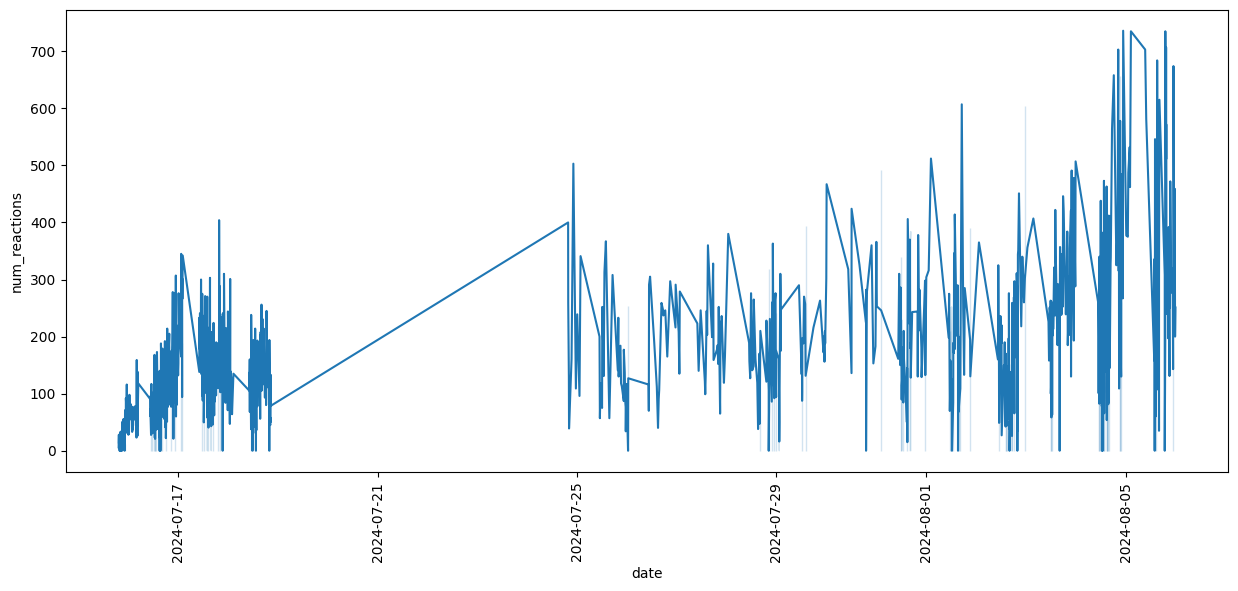

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x=result_df['date'], y=result_df['num_reactions'] )
plt.xticks(rotation=90,)

In [95]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.026346  0.037207       1        1  38.121055
2     -0.029060 -0.036012       2        1  35.483598
0      0.055406 -0.001196       3        1  26.395347, topic_info=              Term         Freq        Total Category  logprob  loglift
2       media_imag  5094.000000  5094.000000  Default  30.0000  30.0000
0         ছাত্রলীগ  1170.000000  1170.000000  Default  29.0000  29.0000
5               হয়  2262.000000  2262.000000  Default  28.0000  28.0000
200       কর্মসূচি  1056.000000  1056.000000  Default  27.0000  27.0000
269          মিছিল   628.000000   628.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
20   বিশ্ববিদ্যালয়   317.258139  2008.864950   Topic3  -5.4903  -0.5136
296   বৈষম্যবিরোধী   256.645474  1331.461152   Topic3  -5.7024  -0.3144
107            রাখ   197.700696   689.144018   Topic3  -5.9633   0.0833
196         আহ্বান   188.500914   659.165390   Topic3  -6.0110   0.0801
169            সকল   218.423813  1662.514039   Topic3  -5.8636  -0.6977

[294 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4190      3  0.965519     authent
4333      3  0.971013       brave
5518      1  0.906533  chattogram
5518      2  0.036261  chattogram
5518      3  0.072523  chattogram
...     ...       ...         ...
5125      1  0.937406        ৩.৫২
3224      2  0.946770       ৪৭০কো
5449      1  0.106793         ৬টা
5449      2  0.017799         ৬টা
5449      3  0.889942         ৬টা

[488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [86]:
result_df_subset['text_plain'].str.contains('media_').sum()

893

In [87]:
len(result_df_subset)

1348